# Behavorial Cloning Model

This is the model I made that uses a deep convolutional neural network to train a car to drive itself.

Using TensorFlow backend.


Left image shape: (160, 320, 3)
Center image shape: (160, 320, 3)
Right image shape: (160, 320, 3)
Training Set: 4112
Validation Set: 1028
Testing Set: The testing is all taken car of by the simulator

Sample left, center, and right images:


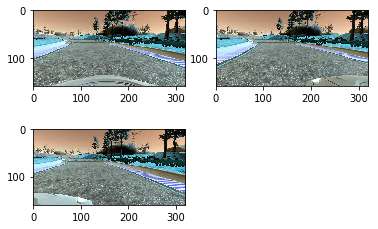

In [1]:
import csv
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

EPOCH = 10
batch_size = 32

def generator(samples, batch_size):
    """Generator for reading image data from csv file"""
    num_samples = len(samples)
    while 1:
    	# Shuffle samples to avoid overfitting
        shuffle(samples)
        # For every batch of 32 samples
        for offset in range(0, num_samples, batch_size):
        	# Capture all 32 samples in this batch inside a variable
            batch_samples = samples[offset:offset+batch_size]
            # Create lists to hold images and angles
            images = []
            angles = []
            # For every sample in the current batch (row in the csv file)
            for batch_sample in batch_samples:
            	# For sample 0, 1, and 2 (row 1, 2, and 3 in csv)
                for i in range(3):
                	# Save the file path from the csv file into a variable
                    source_path = batch_sample[i]
                    # Get the file name from the file path
                    filename = source_path.split('/')[-1]
                    # save the file path from this model to the image
                    current_path = 'data/IMG/' + filename
                    # save the image in a variable
                    image = cv2.imread(current_path)
                    # Add the image to the list of images
                    images.append(image)
                    # Get the data from the row's 'angle' column
                    angle = float(batch_sample[3])
                    # if it is a left image
                    if i == 1:
                    	#  adjust steering to the right
                        angle += 0.1
                    # if it is a right image
                    elif i == 2:  
                    	#  adjust steering to the left
                        angle -= 0.1
                    # Add the new angle to the list
                    angles.append(angle)
            # Save the images into a numpy array
            X_train = np.array(images)
            # Save the angles into a numpy array
            y_train = np.array(angles)
            # Save the generator
            yield shuffle(X_train, y_train)

# read image path and associated measurements from driving log csv file
rows = []
with open('data/driving_log.csv') as csvfile:
	# Read csv file into program
    data_file = csv.reader(csvfile)
    # skip header row
    next(data_file)
    # For each row of the csv file, add it to the array
    for row in data_file:
        rows.append(row)

# split the image dataset for validation
train_samples, validation_samples = train_test_split(rows, test_size=0.2)
# prepare generators for training and validation sets
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

# Get file path from root
left_img_path = train_samples[0][0]
center_img_path = train_samples[0][1]
right_img_path = train_samples[0][2]

# Get the file name from the file path
left_img_filename = left_img_path.split('/')[-1]
center_img_filename = center_img_path.split('/')[-1]
right_img_filename = right_img_path.split('/')[-1]

# save the file path from model to the image
left_img_current_path = 'data/IMG/' + left_img_filename
center_img_current_path = 'data/IMG/' + center_img_filename
right_img_current_path = 'data/IMG/' + right_img_filename

# save images in a variable
left_image = cv2.imread(left_img_current_path)
center_image = cv2.imread(center_img_current_path)
right_image = cv2.imread(right_img_current_path)

print("Left image shape: {}".format(left_image.shape))
print("Center image shape: {}".format(center_image.shape))
print("Right image shape: {}".format(right_image.shape))
print("Training Set: {}".format(len(train_samples)))
print("Validation Set: {}".format(len(validation_samples)))
print("Testing Set: The testing is all taken car of by the simulator\n")

fig = plt.figure()
print("Sample left, center, and right images:")
fig.add_subplot(2,2,1)
plt.imshow(left_image.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(center_image.squeeze(), cmap="gray")
fig.add_subplot(2,2,3)
plt.imshow(right_image.squeeze(), cmap="gray")

Epoch 1/10
12336/12336 [==============================] - 134s - loss: 0.0424 - val_loss: 0.0339

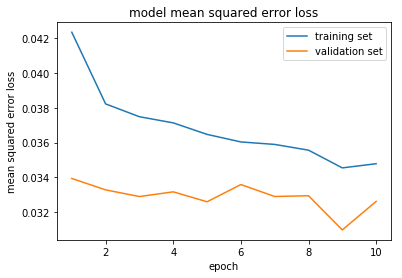

In [2]:
# Nvidia neural network architecture
# https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
model = Sequential()

# Lambda with normalization and cropping
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))

# Layer 1 - Convolutional
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 2 - Convolutional
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 3 - Convolutional
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 4 - Convolutional
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(1))

# Layer 5 - Convolutional
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(1))

# Layer 6 - Flatten
model.add(Flatten())

# Layer 7 - Fully Connected
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 8 - Fully Connected
model.add(Dense(50))
model.add(Activation('relu'))

# Layer 9 - Fully Connected
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 10 - Fully Connected
model.add(Dense(1))


# train the model
model.compile(loss='mse', optimizer='adam')
fit_generator = model.fit_generator(
    train_generator, samples_per_epoch=len(train_samples)*3,
    validation_data=validation_generator, nb_val_samples=len(validation_samples)*3,
    nb_epoch=EPOCH)

# plot training history
plot_x = np.arange(1, EPOCH+1)
plt.plot(plot_x, fit_generator.history['loss'])
plt.plot(plot_x, fit_generator.history['val_loss'])
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('training_history_dropout.png')

# save model
model.save('model.h5')
